# Objetivos del proyecto.

Vamos a analizar un conjunto de datos de la Universidad de Wisconsin, que contiene información sobre pacientes con posible cáncer de mama, junto con su clasificación (diagnóstico positivo o negativo).

Nuestro objetivo será entrenar y comparar diversos modelos de conjunto (ensemble models) para evaluar su desempeño.

Dado que este es un problema de diagnóstico médico, priorizaremos la métrica de recall, definida como: $$Recall=\frac{True positives}{True positives + False Negatives},$$ ya que tiene más importancia detectar todos los posibles casos de cancer aunque esto nos lleve a dar algún falso positivo. 

_Es importante notar que en la práctica clínica moderna, el sobrediagnóstico del cáncer de mama es un tema muy importante. Detectar un cáncer que nunca habría causado síntomas o problemas en la vida de la paciente puede llevar a tratamientos innecesarios. De hecho, el sobrediagnóstico es actualmente uno de los principales inconvenientes de la práctica extendida de mamografías. Para más información, véase el artículo:  https://pmc.ncbi.nlm.nih.gov/articles/PMC5365181/#:~:text=Overdiagnosis%20(overdetection)%20of%20BC%20from,side%20of%20population%20breast%20screening._

En este proyecto, no solo nos interesa la precisión del modelo con respecto a métricas estándar, sino que también es fundamental evaluar su interpretabilidad. En sectores como la salud (y en áreas financieras como la concesión de préstamos hipotecarios), es indispensable entender por qué un modelo toma ciertas decisiones. Para lograrlo, utilizaremos la técnica de **Shapley Values**, que permite explicar la contribución de cada variable en las predicciones. Además, exploraremos otras técnicas complementarias para mejorar el análisis de las decisiones del modelo.

# Paquetes

En esta sección simplemente cargaremos todos los paquetes necesarios para llevar a cabo el análisis.

In [1]:
# Load libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

# Cargando y explicando el dataset

A continuación cargamos el dataset y sus metadatos para analizarlo.

In [ ]:
from ucimlrepo import fetch_ucirepo 
  

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

print(breast_cancer_wisconsin_diagnostic.metadata) 
   
print(breast_cancer_wisconsin_diagnostic.variables) 

df = pd.concat([X, y], axis=1)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

Puesto que los metadatos no contienen demasiada información, vamos a explicar un poco las caracterisitcas de este conjunto de datos. Los detalles que se presentan a continuación pueden encontrarse en:https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic.

# Conjunto de Datos: Breast Cancer Wisconsin (Diagnostic)

El conjunto de datos **Breast Cancer Wisconsin (Diagnostic)** contiene información derivada de imágenes digitalizadas de aspiraciones con aguja fina (**FNA**) de masas mamarias.  
Cada instancia representa características de los núcleos celulares presentes en la imagen.

## Columnas del Conjunto de Datos

### Identificación y Diagnóstico
- **ID**: Número de identificación del paciente.
- **Diagnóstico**: Clasificación del tumor, donde **"M"** indica maligno y **"B"** indica benigno.

### Características de los Núcleos Celulares
Para cada núcleo celular, se calcularon **10 características reales**:

1. **Radio**: Promedio de las distancias desde el centro hasta los puntos en el perímetro.
2. **Textura**: Desviación estándar de los valores de escala de grises.
3. **Perímetro**: Longitud del perímetro del núcleo.
4. **Área**: Área del núcleo.
5. **Suavidad**: Variación local en las longitudes del radio.
6. **Compacidad**: $ \text{Perímetro}^2 / \text{Área} - 1.0 .$
7. **Concavidad**: Severidad de las porciones cóncavas del contorno.
8. **Puntos cóncavos**: Número de porciones cóncavas del contorno.
9. **Simetría**: Simetría del núcleo.
10. **Dimensión fractal**: "Aproximación de la línea de costa" - 1.

### Valores Calculados para Cada Característica
Para cada una de estas 10 características, se calcularon **tres valores**:

- **Media**: Valor promedio de la característica.  
- **Error estándar**: Desviación estándar de la característica.  
- **Peor valor**: Mayor valor observado (promedio de los tres valores más grandes).  

Esto da lugar a un total de **30 columnas de características** en el conjunto de datos.

### Ejemplo de Columnas en el Dataset

| Tipo | Radio | Textura | Perímetro |
|------|-------|---------|-----------|
| **Media** | `radius_mean` | `texture_mean` | `perimeter_mean` |
| **Error estándar** | `radius_se` | `texture_se` | `perimeter_se` |
| **Peor valor** | `radius_worst` | `texture_worst` | `perimeter_worst` |

Y así sucesivamente para las demás características.

Puesto que queda mucho más claro tener los nombres con _mean _se y _worst en lugar de 1 2 y 3, los sustituimos a continuación.


In [27]:
df.columns = df.columns.str.replace('1', '_mean').str.replace('2', '_se').str.replace('3', '_worst')
print(df.shape)
df.head()


(569, 31)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,0.242,0.079,...,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119,M
1,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,0.181,0.057,...,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089,M
2,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,0.207,0.060,...,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088,M
3,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,0.260,0.097,...,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173,M
4,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,0.181,0.059,...,16.67,152.20,1575.0,0.137,0.205,0.400,0.163,0.236,0.077,M


Vamos también a guardar los subconjuntos de columnas en variables para usarlas durante el resto del proyecto.

In [32]:
mean_columns = [col for col in df.columns if col.endswith('_mean')]
se_columns = [col for col in df.columns if col.endswith('_se')]
worst_columns = [col for col in df.columns if col.endswith('_worst')]
target='Diagnosis'

# Fase preprocesado

## Estadistica basica

In [30]:
pd.set_option('display.precision', 3)
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,14.127,19.290,91.969,654.889,0.096,0.104,0.089,0.049,0.181,0.063,...,16.269,25.677,107.261,880.583,0.132,0.254,0.272,0.115,0.290,0.084
std,3.524,4.301,24.299,351.914,0.014,0.053,0.080,0.039,0.027,0.007,...,4.833,6.146,33.603,569.357,0.023,0.157,0.209,0.066,0.062,0.018
min,6.981,9.710,43.790,143.500,0.053,0.019,0.000,0.000,0.106,0.050,...,7.930,12.020,50.410,185.200,0.071,0.027,0.000,0.000,0.157,0.055
25%,11.700,16.170,75.170,420.300,0.086,0.065,0.030,0.020,0.162,0.058,...,13.010,21.080,84.110,515.300,0.117,0.147,0.115,0.065,0.250,0.071
50%,13.370,18.840,86.240,551.100,0.096,0.093,0.062,0.034,0.179,0.062,...,14.970,25.410,97.660,686.500,0.131,0.212,0.227,0.100,0.282,0.080
75%,15.780,21.800,104.100,782.700,0.105,0.130,0.131,0.074,0.196,0.066,...,18.790,29.720,125.400,1084.000,0.146,0.339,0.383,0.161,0.318,0.092
max,28.110,39.280,188.500,2501.000,0.163,0.345,0.427,0.201,0.304,0.097,...,36.040,49.540,251.200,4254.000,0.223,1.058,1.252,0.291,0.664,0.207


In [31]:
# class distribution
df.groupby('Diagnosis').size()

Diagnosis
B    357
M    212
dtype: int64

## Visualización

In [57]:
def violin_plotter(df, features, split_column=None, palette=None, ax=None):
    """
    Creates violin plots for the given features, standardized, optionally grouped by a categorical column.
    Supports subplotting for side-by-side comparisons.

    Parameters:
    - df (DataFrame): The dataset containing numerical features.
    - features (list): List of feature names to plot.
    - split_column (str, optional): Column used to split the violin plots. If None, plots without classes.
    - palette (dict, optional): Dictionary defining colors for categories in the split_column.
    - ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib subplot axis for side-by-side plotting.

    Returns:
    - None (Displays the violin plot inside the given subplot).
    """

    df = df.copy()  # Avoid modifying the original dataset

    # Standardize the features
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df_scaled[features])

    # Reshape data for Seaborn (Melt the dataframe)
    if split_column and split_column in df.columns:
        df_scaled[split_column] = df_scaled[split_column].astype('category')  # Ensure categorical type
        df_melted = df_scaled.melt(id_vars=[split_column], value_vars=features, 
                                   var_name="Feature", value_name="Standardized Value")
    else:
        df_melted = df_scaled.melt(value_vars=features, var_name="Feature", value_name="Standardized Value")
        split_column = None  # Ensure it's set to None for plotting

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6)) 

    # Create the violin plot
    if split_column:
        sns.violinplot(x="Feature", y="Standardized Value", hue=split_column, data=df_melted, 
                       split=True, inner="quartile", palette=palette, ax=ax)
        ax.legend(title=split_column)
    else:
        sns.violinplot(x="Feature", y="Standardized Value", data=df_melted, inner="quartile", color="skyblue", ax=ax)

    # Improve aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title("Standardized Distribution of Features" + (f" by {split_column}" if split_column else ""))
    return None


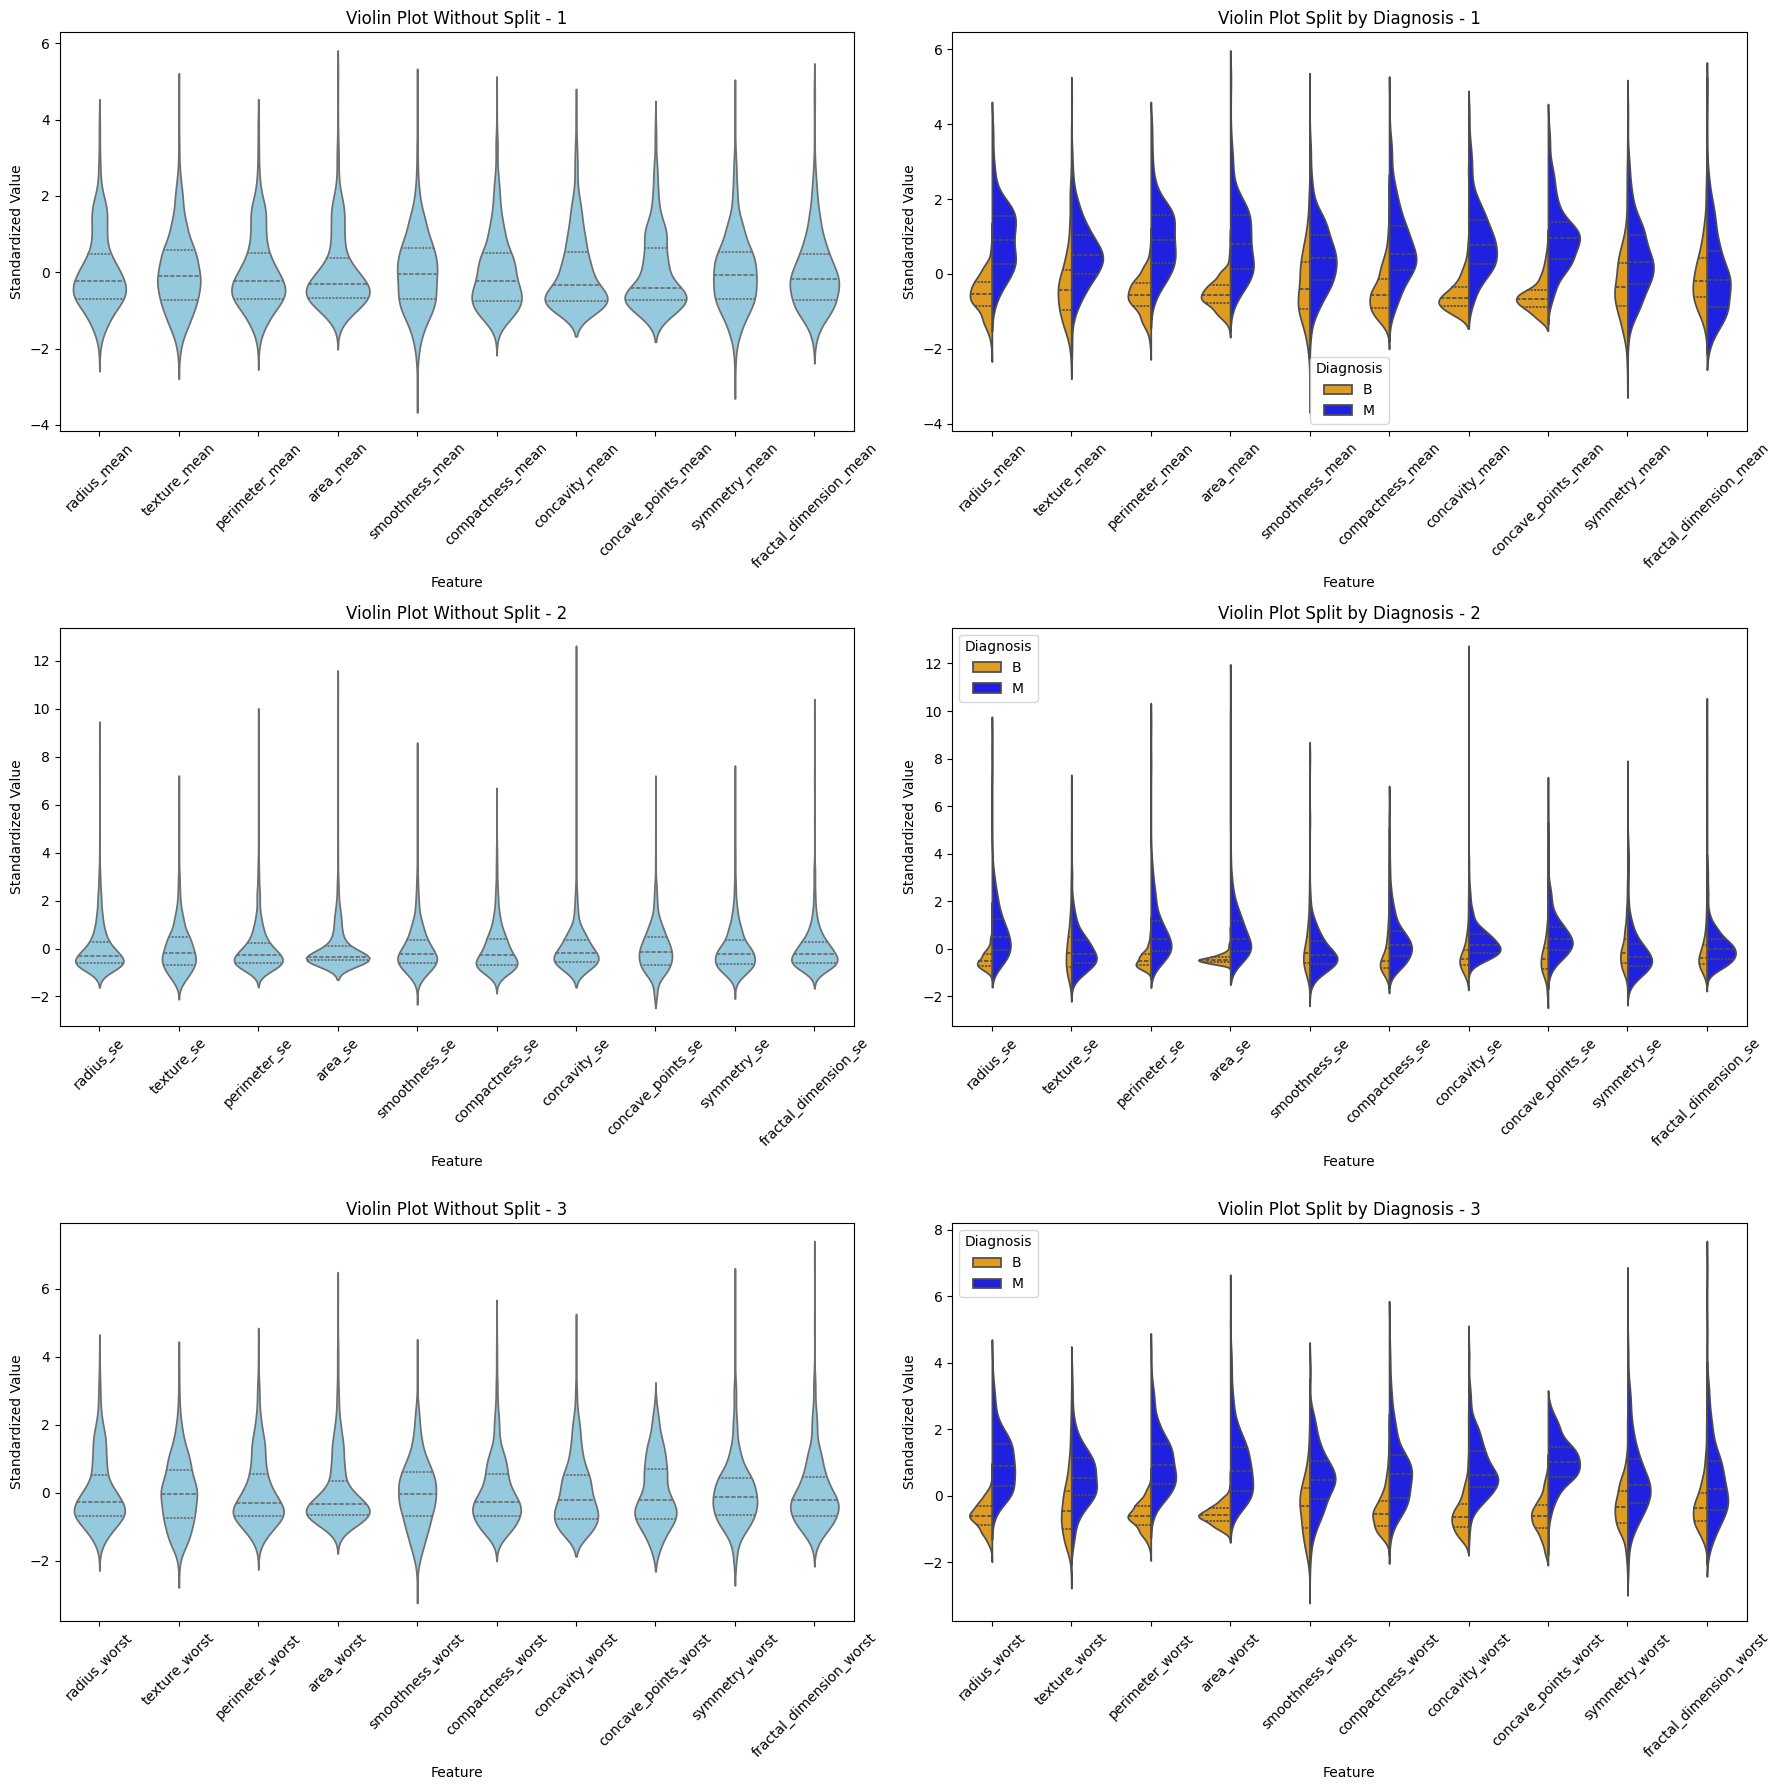

In [60]:
palette = {"M": "blue", "B": "orange"}

fig, axes = plt.subplots(3, 2, figsize=(18, 18)) 

# List of feature sets for each row (customize as needed)
feature_groups = [
    mean_columns,  # Row 1, Left: Mean Features
    se_columns,    # Row 2, Left: SE Features
    worst_columns  # Row 3, Left: Worst Features
]

for i, ax_row in enumerate(axes):

    violin_plotter(df, feature_groups[i], ax=ax_row[0])
    ax_row[0].set_title(f"Violin Plot Without Split - {i+1}")

    violin_plotter(df, feature_groups[i], split_column="Diagnosis", palette=palette, ax=ax_row[1])
    ax_row[1].set_title(f"Violin Plot Split by Diagnosis - {i+1}")


plt.tight_layout()
plt.show()


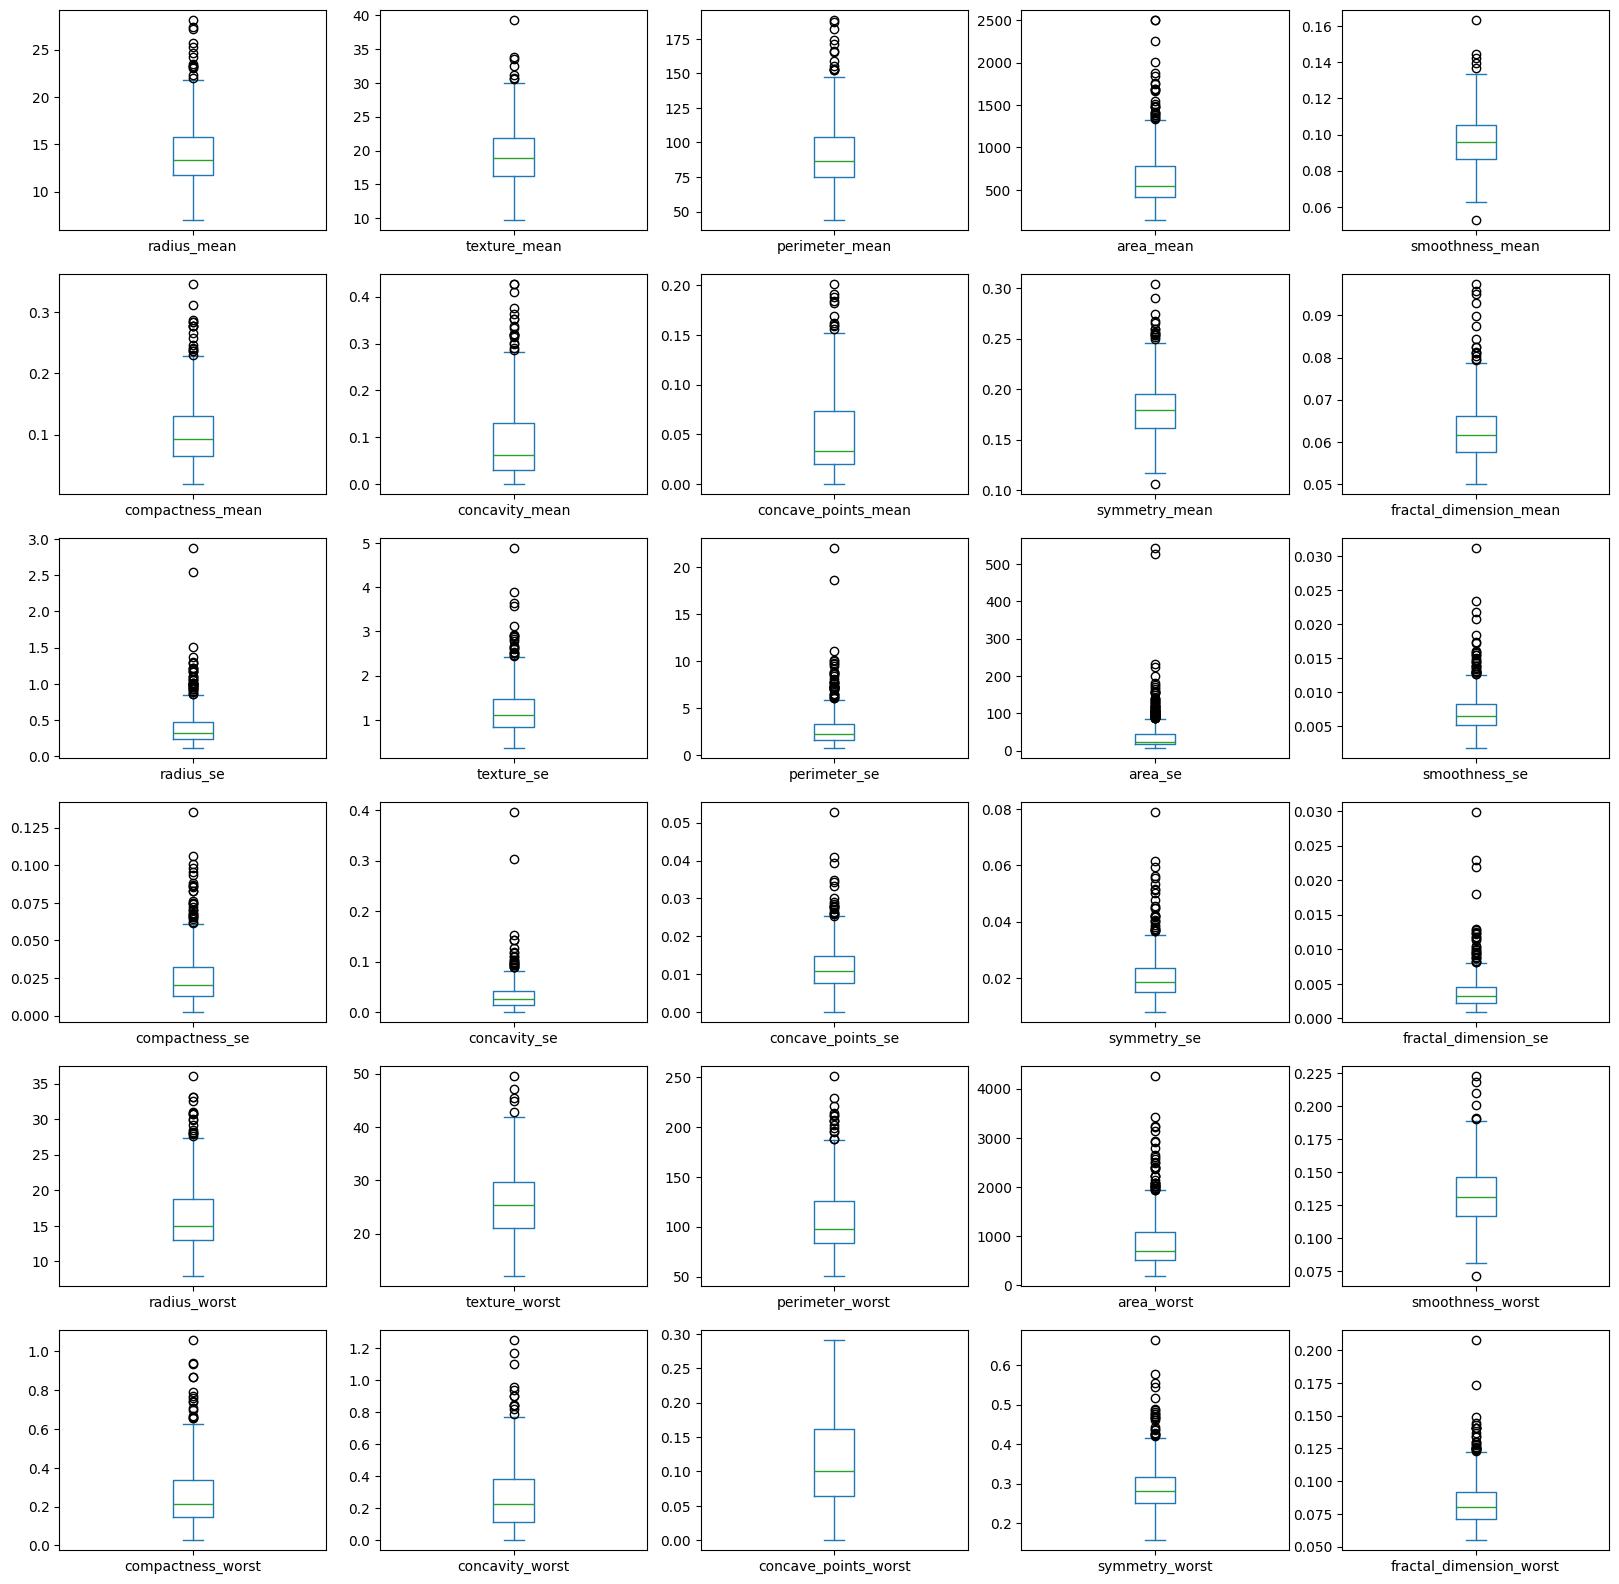

In [28]:
# box and whisker plots - Matplotlib
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
(df.rename(columns=lambda x: str(x))
        .plot(ax=ax, kind= 'box', subplots=True, layout=(6,5))
)
plt.show()

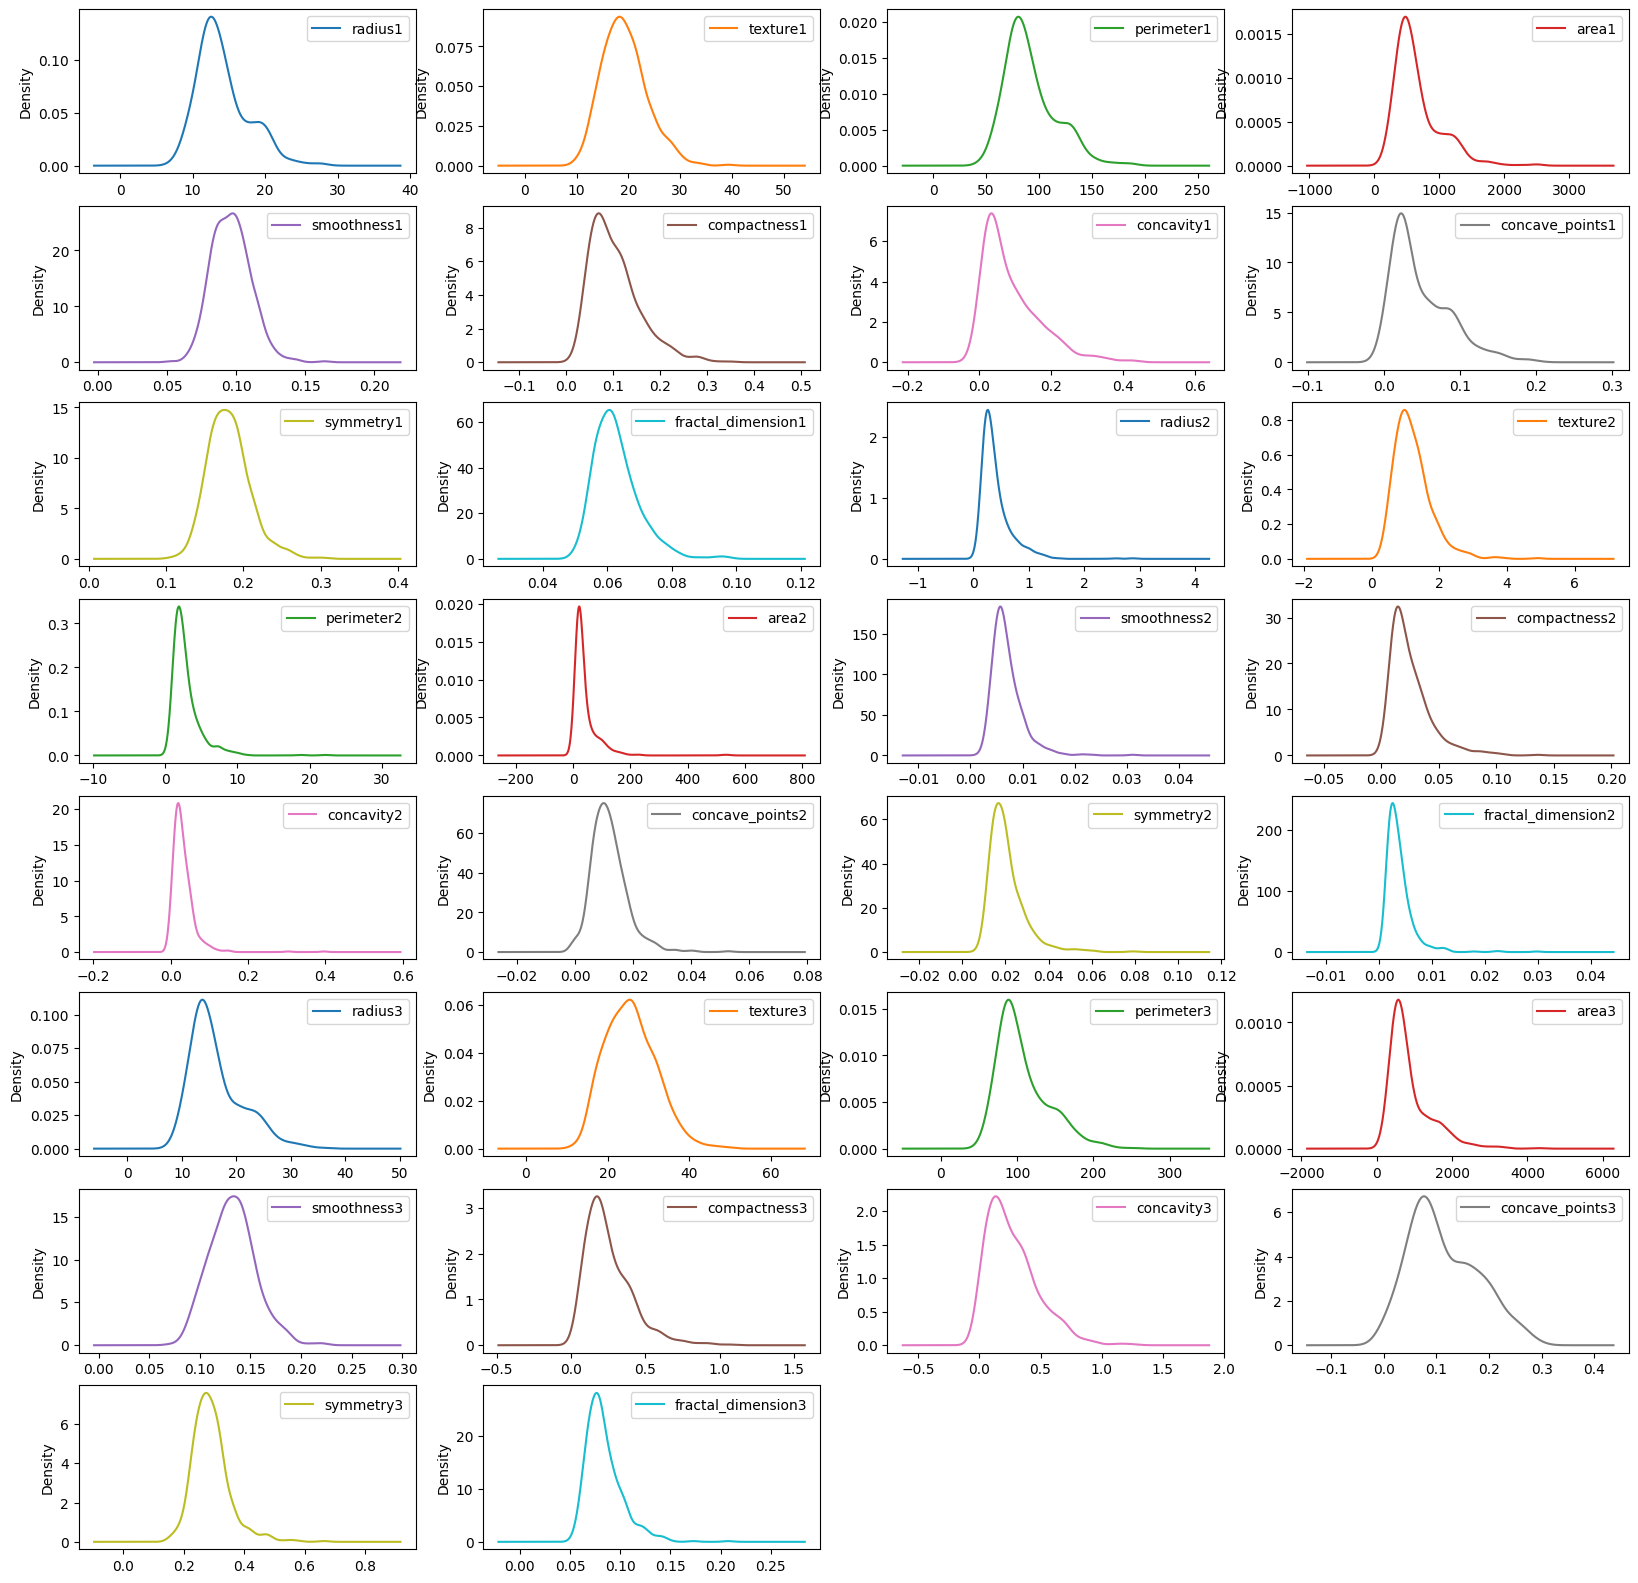

In [7]:
# density
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
df.plot(ax=ax, kind='density', subplots=True, layout=(8,4), sharex=False, legend=True)
plt.show()

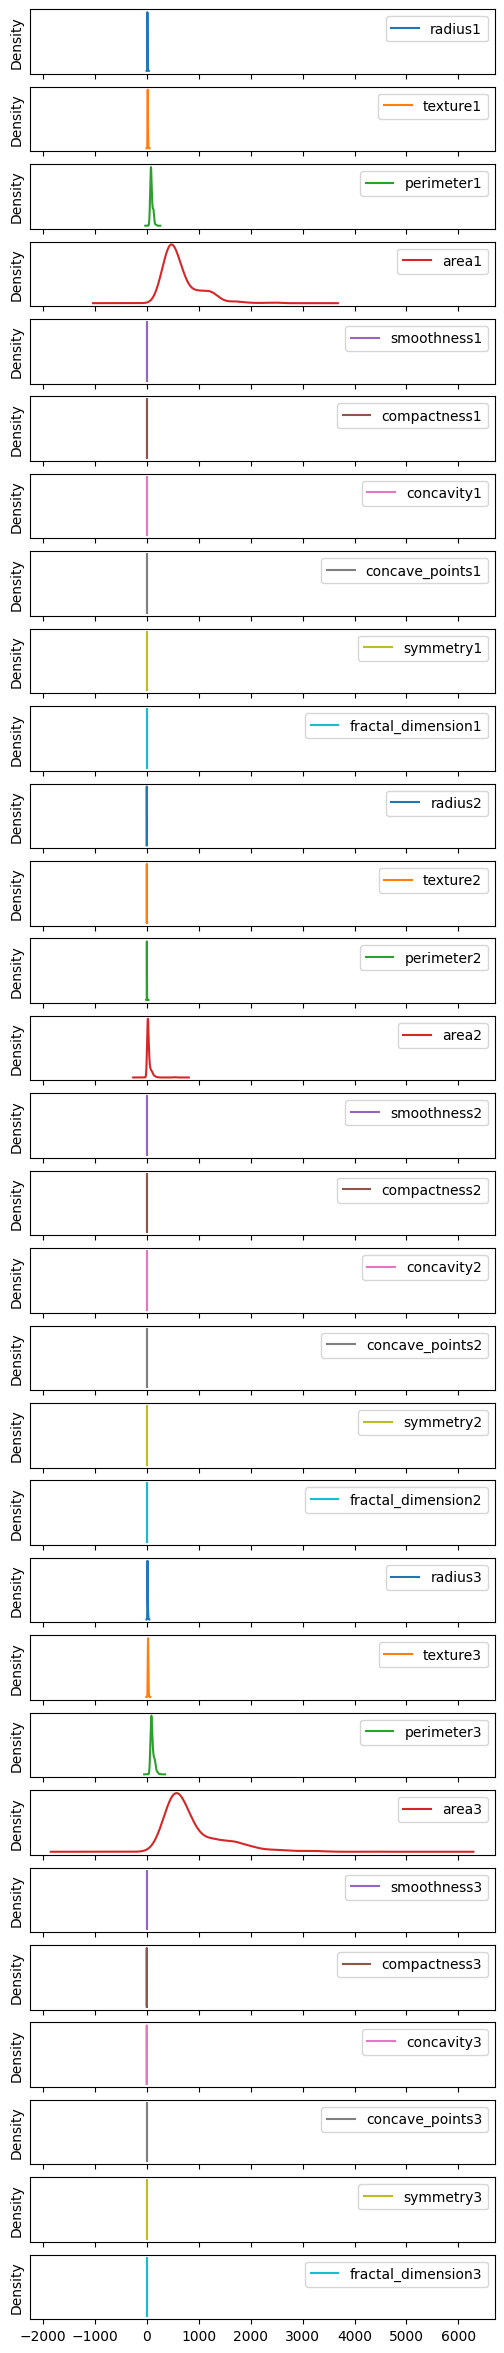

In [8]:
df.plot.density(figsize=(6, 30), subplots=True, yticks=[])
pass

## Correlaciones

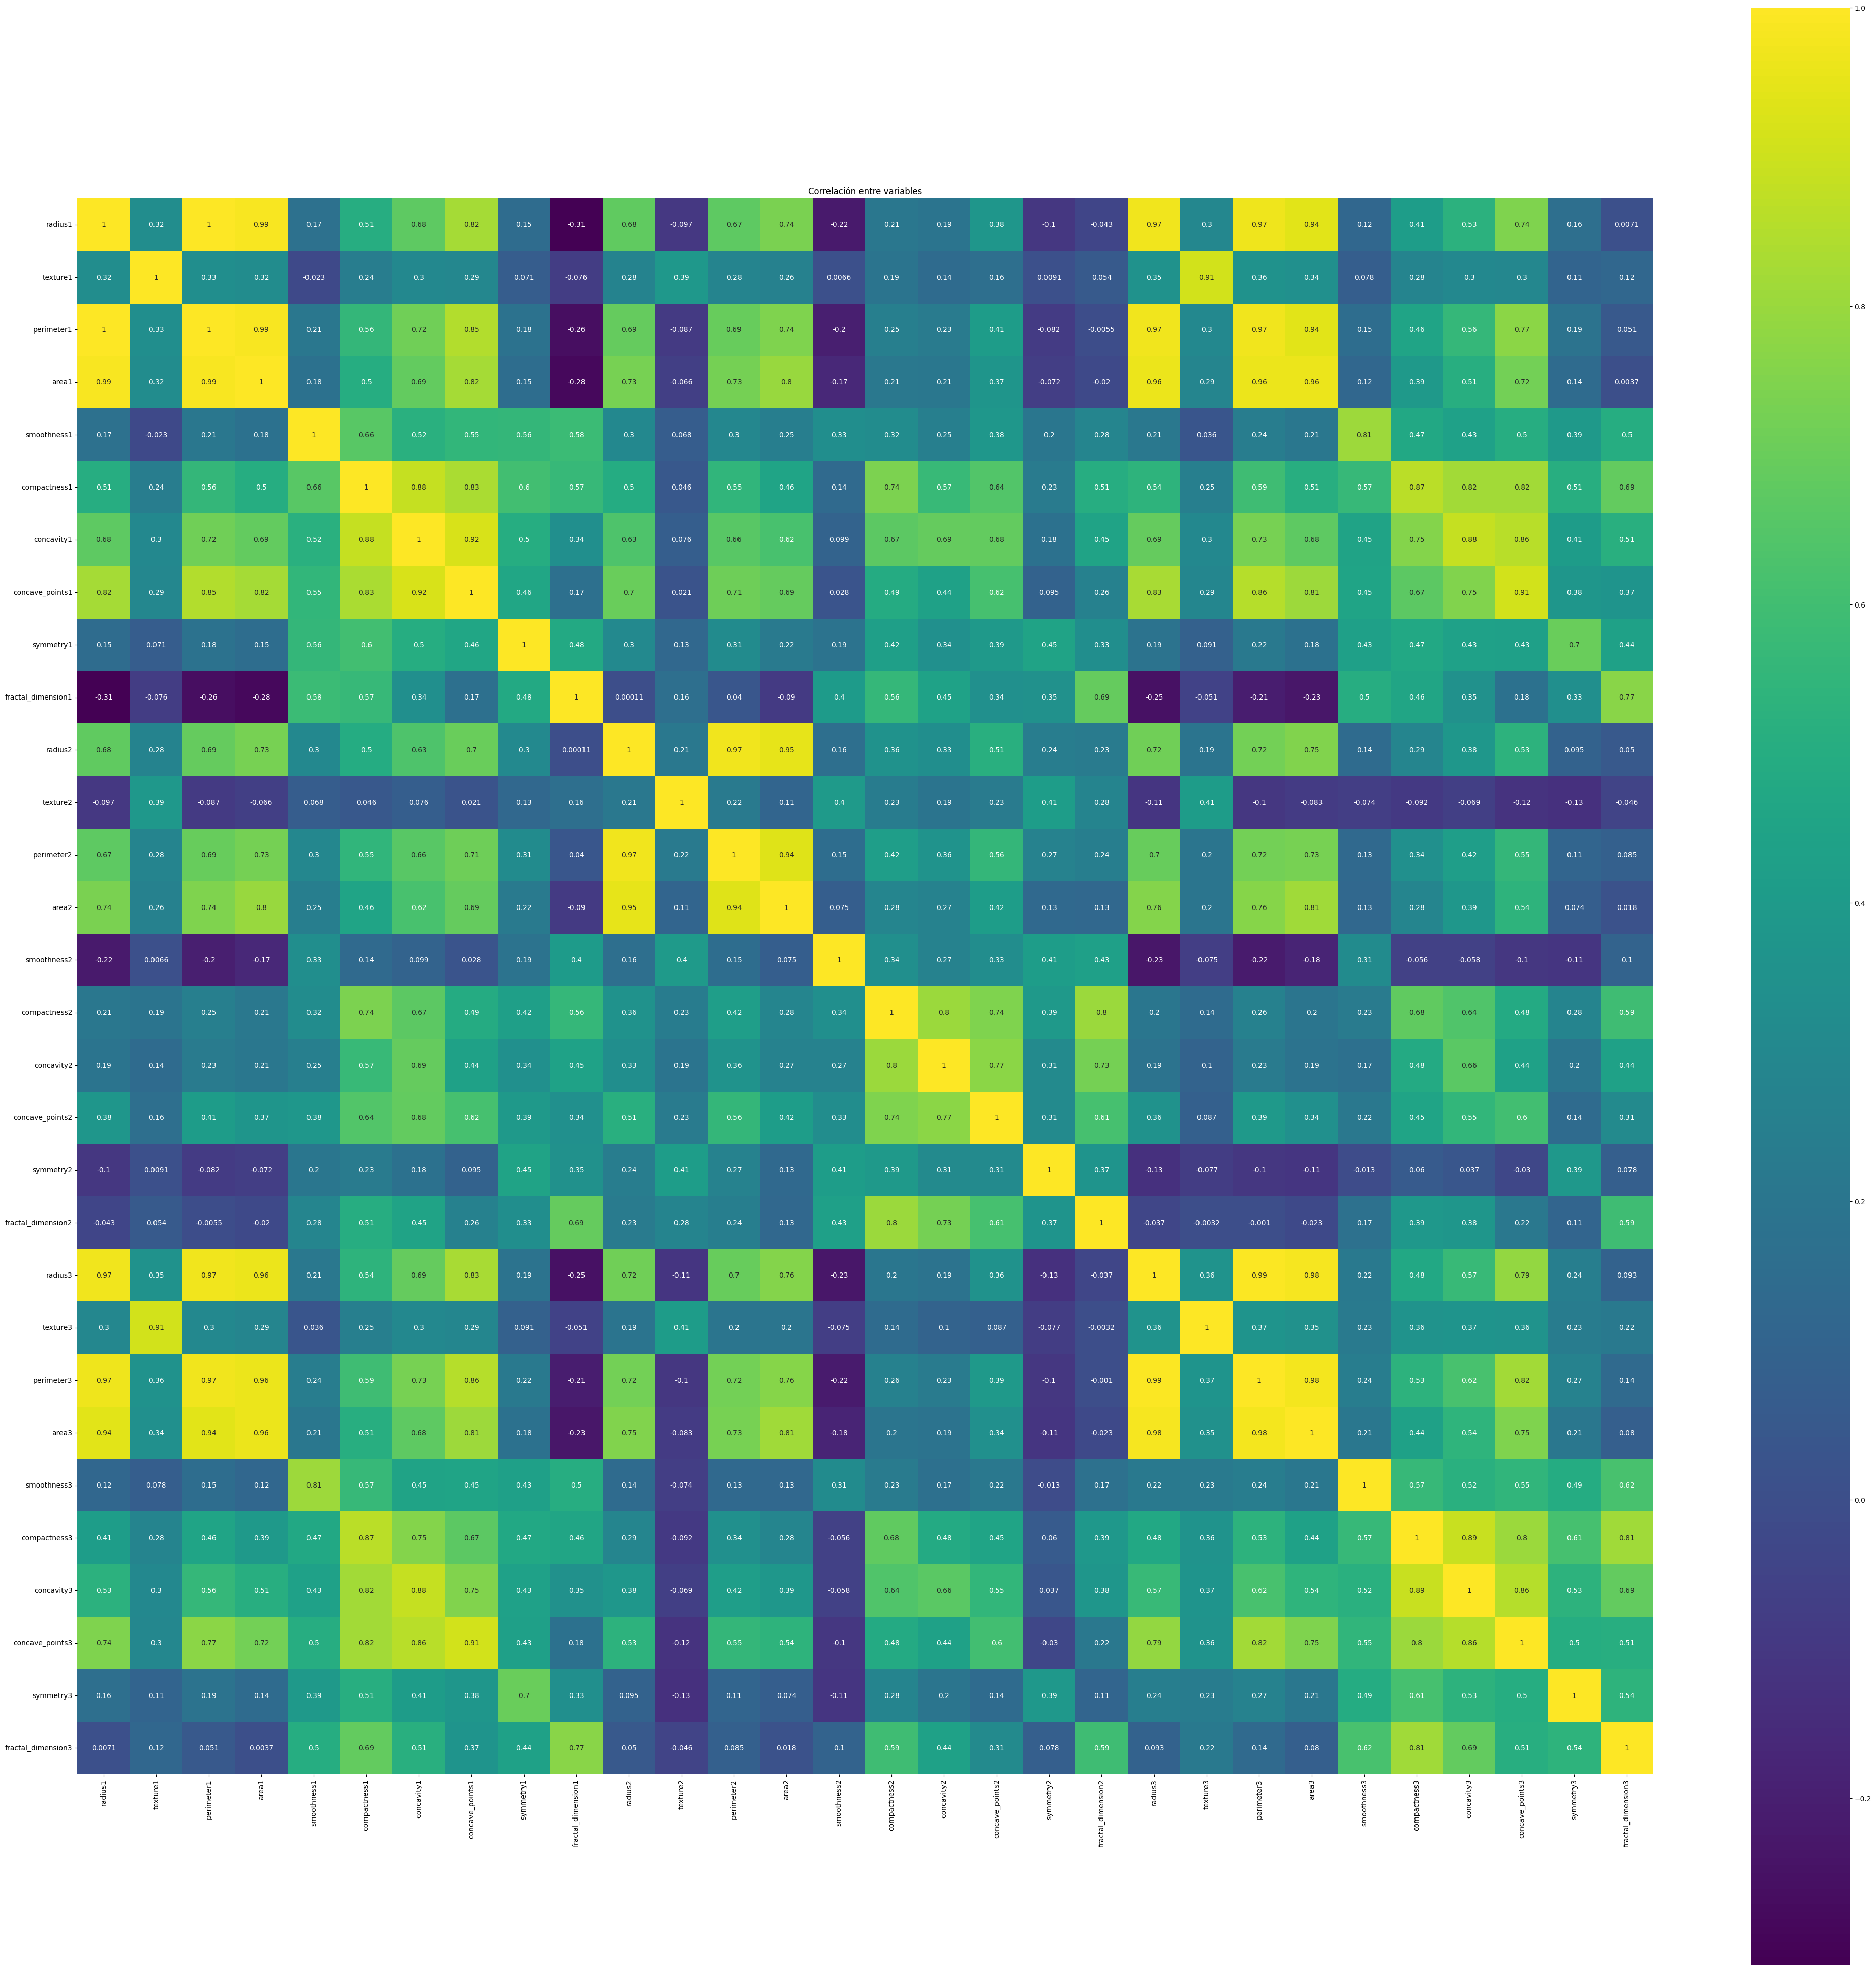

In [9]:
correlation = X.corr()
plt.figure(figsize=(50,50))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
# Esto se ponde debido al bug de Matplotlib 3.1.1 (quitarlo en versiones diferentes)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
# ----------
plt.title('Correlación entre variables')
plt.show()

## Datos normalizados

In [10]:
scaler = StandardScaler()

X_scaled = pd.DataFrame( scaler.fit_transform(X), columns=X.columns)

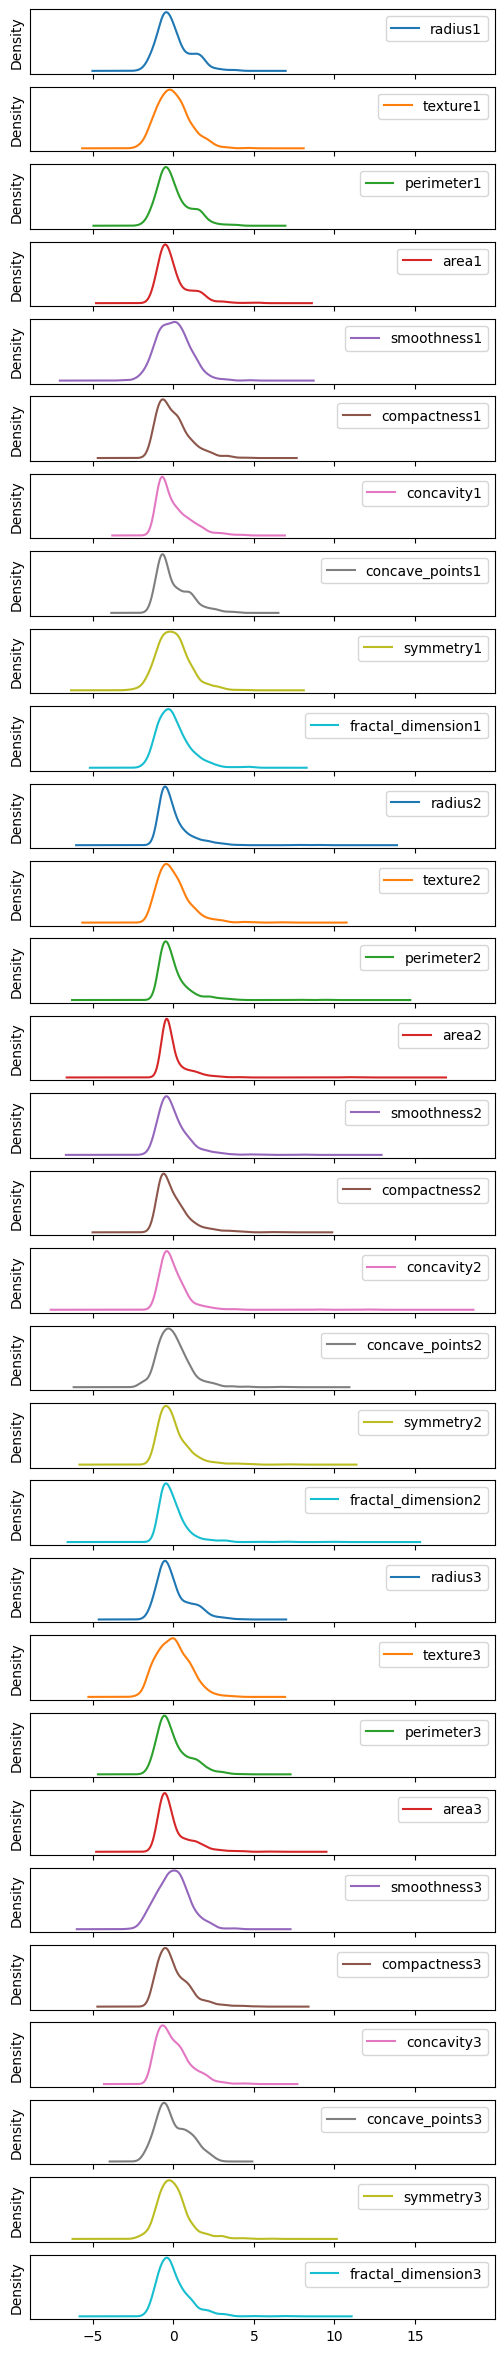

In [11]:
X_scaled.plot.density(figsize=(6, 30), subplots=True, yticks=[])
pass

# Train test split

In [12]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2)

In [13]:
X_train_scaled=scaler.fit_transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [14]:
print(X_train_scaled.shape, y_train.shape)

(455, 30) (455, 1)


## Outliers

## Feature importance

In [15]:
rnf=RandomForestClassifier(500,n_jobs=-1)
rnf.fit(X_train_scaled,y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

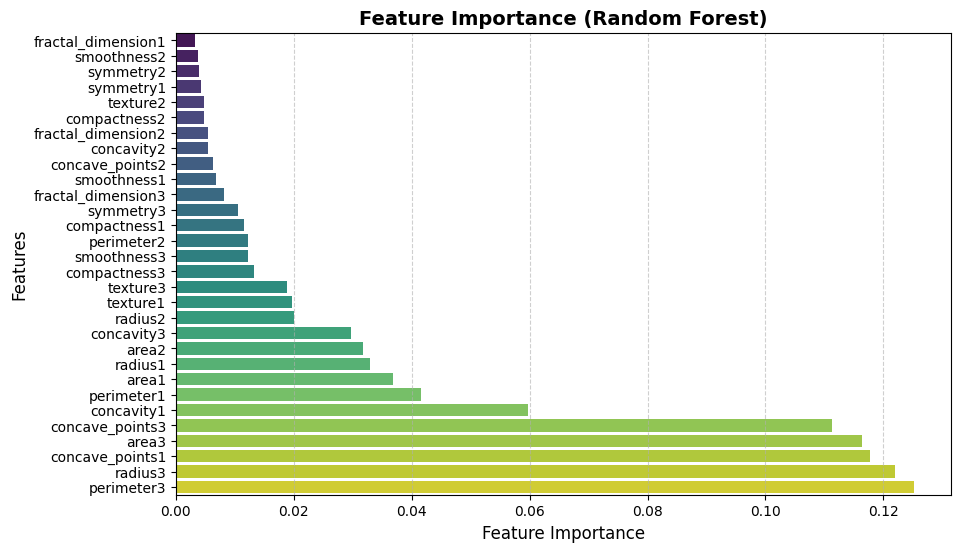

In [16]:
feat_importances = pd.Series(rnf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="viridis")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance (Random Forest)", fontsize=14, fontweight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

In [17]:
num_runs = 50

# Store feature importances for each run
feature_importances = np.zeros((num_runs, X_train_scaled.shape[1]))

# Run Random Forest multiple times
for i in range(num_runs):
    rnf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    rnf.fit(X_train_scaled, y_train)
    feature_importances[i, :] = rnf.feature_importances_

# Compute the average and standard deviation of feature importance
avg_importances = feature_importances.mean(axis=0)
std_importances = feature_importances.std(axis=0)

# Convert to Pandas Series for visualization
#feat_importances = pd.Series(avg_importances, index=X_train.columns).sort_values(ascending=True)
feat_importances = pd.Series(avg_importances, index=X_train_scaled.columns).sort_values(ascending=True)
std_sorted = pd.Series(std_importances, index=X_train_scaled.columns).loc[feat_importances.index]

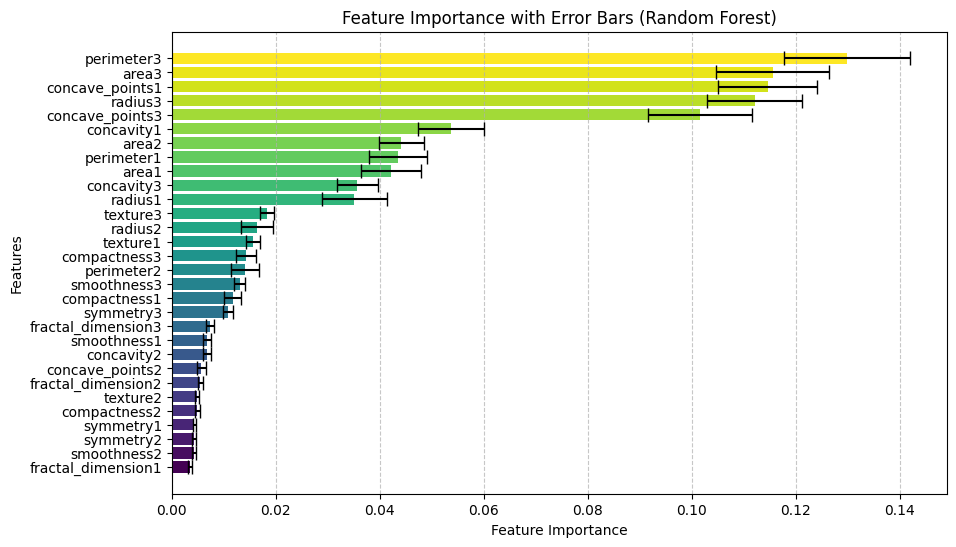

In [18]:
feature_importance_df = pd.DataFrame({
    'Feature': feat_importances.index,
    'Importance': feat_importances.values,
    'Std Dev': std_sorted.values}) 

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], 
        feature_importance_df['Importance'], 
        xerr=feature_importance_df['Std Dev'], 
        capsize=5, color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df))))
    
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance with Error Bars (Random Forest)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [19]:
important_columns=feature_importance_df.nlargest(11, 'Importance')['Feature'].to_list()

In [20]:
X_filtered=X_train_scaled[important_columns]
X_filtered

,perimeter3,area3,concave_points1,radius3,concave_points3,concavity1,area2,perimeter1,area1,concavity3,radius1
0,0.197,0.055,1.081,0.190,0.715,0.486,-0.123,0.202,0.016,0.137,0.161
1,0.069,-0.140,0.050,0.038,0.361,-0.137,-0.369,-0.086,-0.221,0.020,-0.118
2,-0.475,-0.452,-0.540,-0.438,-0.382,-0.098,-0.549,-0.265,-0.307,0.272,-0.240
3,-0.750,-0.728,-0.506,-0.821,-0.549,-0.500,-0.319,-0.914,-0.824,-0.632,-0.931
4,-0.062,-0.226,0.952,-0.057,0.423,0.321,-0.028,0.292,0.034,-0.370,0.252
...,...,...,...,...,...,...,...,...,...,...,...
450,2.915,3.548,1.951,3.013,2.216,1.357,2.373,2.520,2.839,1.470,2.558
451,-0.564,-0.633,0.298,-0.629,-0.065,0.228,-0.429,-0.428,-0.513,-0.248,-0.450
452,-1.069,-0.859,-0.597,-1.037,-1.098,-0.829,-0.458,-0.922,-0.817,-1.117,-0.891
453,1.062,0.576,2.315,0.714,2.015,2.921,2.015,0.731,0.313,1.643,0.411


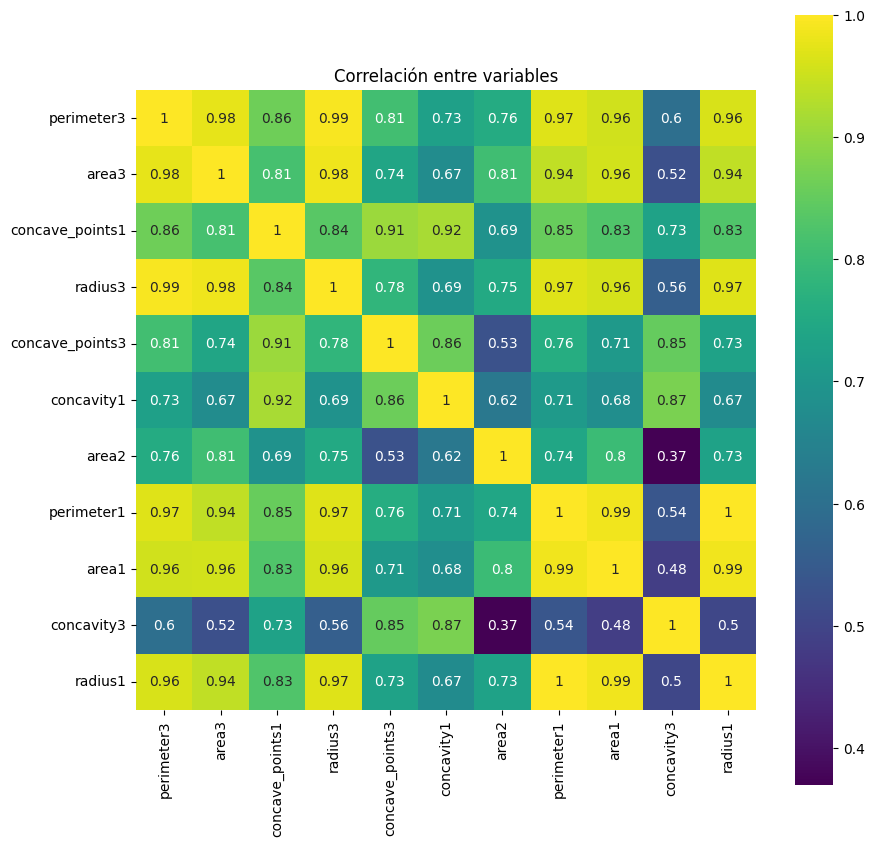

In [21]:
correlation = X_filtered.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
# Esto se ponde debido al bug de Matplotlib 3.1.1 (quitarlo en versiones diferentes)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
# ----------
plt.title('Correlación entre variables')
plt.show()

# Model training

## Bagging

## Random forest and extra trees

## Boosting

## Staking